In [1]:
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/EPFL/AppliedDataScience/Project/ada-2022-project-adlucere2022/src/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Imports

In [70]:
# Basic Stuff
import pandas as pd
import numpy as np
from scipy import stats
from itertools import combinations

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

#ML
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

import statsmodels.formula.api as smf

In [3]:
# Matplotlib parameters customization
def set_mpl_params(COLOR = 'black'):  
  mpl.rcParams['text.color'] = COLOR
  mpl.rcParams['font.weight'] = 'normal'
  mpl.rcParams['figure.titleweight'] = 'normal'
  mpl.rcParams['axes.labelcolor'] = COLOR
  mpl.rcParams['axes.edgecolor'] = COLOR
  mpl.rcParams['xtick.color'] = COLOR
  mpl.rcParams['ytick.color'] = COLOR
  mpl.rcParams['figure.facecolor'] = (1,1,1,0)
  mpl.rcParams['savefig.facecolor'] = (0,0,0,0)
  mpl.rcParams['savefig.transparent'] = False

Load data and merge with factor and topics assignation

In [4]:
factors = pd.read_csv(path + "../data/clustering/factor_assignment.csv")
topics = pd.read_csv(path + "../data/clustering/movie_topic_distribution.csv")

data = pd.read_csv(path + "../data/movie_data_imdbscores_final.csv").drop('plot_summary', axis = 1)


data = data.merge(factors, on = 'movie_id').merge(topics, on = 'movie_id').set_index('movie_id')

data.head()

,movie_name,release_date,english_language,german_language,silent_film_language,spanish_language,japanese_language,italian_language,tamil_language,hindi_language,...,F_gender,averageRating,numVotes,factor_1,factor_2,factor_3,topic_1,topic_2,topic_3,topic_4
movie_id,,,,,,,,,,,,,,,,,,,,,
975900,ghosts of mars,2001,True,False,False,False,False,False,False,False,...,0.352941,4.9,55254,0,1,0,0.103689,0.513649,0.076592,0.306070
9363483,white of the eye,1987,True,False,False,False,False,False,False,False,...,0.500000,6.1,2631,0,0,1,0.404839,0.087244,0.171197,0.336720
261236,a woman in flames,1983,False,True,False,False,False,False,False,False,...,0.333333,6.0,590,1,0,0,0.743302,0.006484,0.024737,0.225477
18998739,the sorcerer's apprentice,2002,True,False,False,False,False,False,False,False,...,0.200000,6.5,160,0,1,0,0.372719,0.212864,0.113500,0.300917
12621957,the sorcerer's apprentice,2010,True,False,False,False,False,False,False,False,...,0.312500,6.5,160,0,0,1,0.071356,0.247163,0.171496,0.509985


# Rating Discretization

Plot averageRating distribution

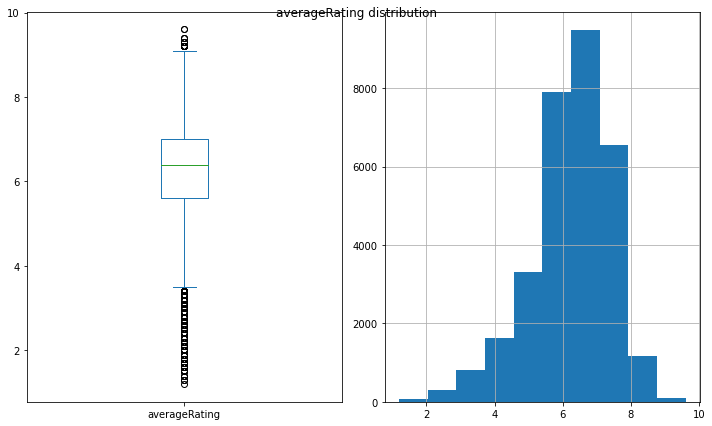

In [5]:
# Plot averageRating distribution

fig, ax = plt.subplots(1, 2, figsize = (10,6))
ax = ax.flatten()
data.averageRating.plot.box(ax = ax[0])
data.averageRating.hist(ax = ax[1])
fig.suptitle("averageRating distribution")
plt.tight_layout()
plt.show()

In [6]:
data.averageRating.describe()

count    31291.000000
mean         6.236113
std          1.164524
min          1.200000
25%          5.600000
50%          6.400000
75%          7.000000
max          9.600000
Name: averageRating, dtype: float64

We discretize the data based on its average rating. The separation is made on quantiles, depending on the amount of categories chosen.

In [7]:
# Discretize feature based on quantiles
def discretize_column(data, n, label_suffix = "_star"):
    
    # Compute proportion for quantile
    p = 1/(n)
    
    # Return semgments
    return pd.cut(data,
                  # Create interval cuts
                  bins = [np.quantile(data, x * p) if x != n else np.inf
                          for x in range(n+1)],
                  right = False,
                  # assign labels
                  labels = [f"{i+1}{label_suffix}" for i in range(n)])

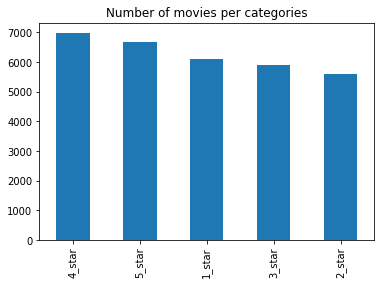

In [8]:
# Perform discretization and save categories in new feature
data["score_discretized"] = discretize_column(data.averageRating, 5)

# Verify Discretization proportions
data.score_discretized.value_counts().plot.bar()
plt.title("Number of movies per categories")
plt.show()

# Testing means accross discretization

Compute empiric means of proportions and numeric values:

In [10]:
# Compute mean proportions and means for numeric values
grouped = data.drop('movie_name', axis = 1).groupby('score_discretized')
grouped_means = grouped.mean()
grouped_means

,release_date,english_language,german_language,silent_film_language,spanish_language,japanese_language,italian_language,tamil_language,hindi_language,malayalam_language,...,F_gender,averageRating,numVotes,factor_1,factor_2,factor_3,topic_1,topic_2,topic_3,topic_4
score_discretized,,,,,,,,,,,,,,,,,,,,,
1_star,1992.321786,0.680512,0.011492,0.007716,0.021835,0.017895,0.021507,0.023149,0.069775,0.019865,...,0.342841,4.420440,3534.902972,0.440650,0.336398,0.222952,0.448480,0.223441,0.090598,0.237481
2_star,1984.500802,0.716907,0.015322,0.010511,0.029396,0.021379,0.020666,0.017103,0.045608,0.012293,...,0.343848,5.727258,6468.271869,0.430786,0.333511,0.235703,0.493833,0.206208,0.103511,0.196448
3_star,1981.038682,0.706250,0.018750,0.014189,0.034966,0.028716,0.023818,0.015372,0.040878,0.011318,...,0.342836,6.304020,9307.742230,0.424324,0.342061,0.233615,0.504014,0.210168,0.100259,0.185558
4_star,1980.180269,0.652778,0.033219,0.019903,0.044387,0.031357,0.030212,0.017039,0.051833,0.016037,...,0.334763,6.842511,13110.968499,0.430126,0.333906,0.235968,0.512678,0.216372,0.088010,0.182940
5_star,1982.277271,0.559479,0.043693,0.015562,0.043094,0.043992,0.035613,0.036810,0.068233,0.026635,...,0.317061,7.624465,43490.467455,0.422415,0.350890,0.226695,0.516674,0.221678,0.074436,0.187213


How different are best and worst scoring groups?

In [11]:
# Visualize the best and worst scoring groups
grouped_means.iloc[[0,-1], :]

,release_date,english_language,german_language,silent_film_language,spanish_language,japanese_language,italian_language,tamil_language,hindi_language,malayalam_language,...,F_gender,averageRating,numVotes,factor_1,factor_2,factor_3,topic_1,topic_2,topic_3,topic_4
score_discretized,,,,,,,,,,,,,,,,,,,,,
1_star,1992.321786,0.680512,0.011492,0.007716,0.021835,0.017895,0.021507,0.023149,0.069775,0.019865,...,0.342841,4.420440,3534.902972,0.440650,0.336398,0.222952,0.448480,0.223441,0.090598,0.237481
5_star,1982.277271,0.559479,0.043693,0.015562,0.043094,0.043992,0.035613,0.036810,0.068233,0.026635,...,0.317061,7.624465,43490.467455,0.422415,0.350890,0.226695,0.516674,0.221678,0.074436,0.187213


Proceed to do t-tests over said means

In [12]:
# test features over dataframe with significance sidak correction
def test_over_variables(n_tests, vars, alpha, t1, t2):

    # Success flag:
    # At least one significant outcome -> underlying effect
    success = False
    
    #List to append significant results
    successes = []
    
    # Save pvalues
    pvalues = []

    print("_____________________________")
    print(f"{n_tests} t-tests with significance: {alpha:0.5f}")

    for var in vars:
        # Test var in both periods of time
        test_result = stats.ttest_ind(t1[var], t2[var])
        
        # If the result is significant...
        if test_result.pvalue < alpha:
            # Flag success true and keep result for future display
            success = True
            successes.append((var, test_result.pvalue))
        
        #print(f't-Test for Var: {var} -> p: {test_result[1]}')
        pvalues.append(test_result.pvalue)
    print("_____________________________")


    # Display significant results
    if success:
        print("Manifestation of underlying effect between groups in vars:")
        for var in successes:
            print(f"{var[0]} -> pvalue: {var[1]}")

    print(f"{len(successes)} / {len(vars)} significative results")
    
    return pvalues

def tester(grouped, grouped_on, alpha, correction = 'sidak', subtype = "by_group"):

  df_list = []

  total_tests = sum([len(df.columns.drop(grouped_on)) for (_, df) in grouped])

  # Iterate on all comparison combinations
  for (label_1,df_1), (label_2, df_2) in combinations(grouped, 2):
      
      # Drop the separating feature
      vars = df_1.columns.drop(grouped_on)
      
      print(">>>>>>>>>>>>>>>>>>>>>>>>>>")
          
      print(f"{label_1} vs {label_2}")

      # Test over all variables with 0.05 significance
      # Make p test adjustment based on number of experiments

      n_tests = len(vars)

      if subtype == 'by_group': # independece by group comparison
        k = n_tests
      else: # independence by all comparisons of groups
        k = total_tests


      if correction == 'sidak':
        # Sidak correction with k = n_tests
        alpha_c = 1 - (1 - alpha)**(1/k)
      else:
        # Bonferroni correction
        alpha_c = alpha / k

      

      pvalues = test_over_variables(n_tests, vars, alpha_c, df_1, df_2)
      
      
      # Save results
      df_list.append(pd.DataFrame([pvalues], index = [f"{label_1}_vs_{label_2}"], columns = vars))
      

  # Append al results
  comparison_df = pd.concat(df_list, axis = 0)

  return comparison_df

In [13]:
print("MEAN PROPORTION OF LANGUAGES GENRES ETC TEST")

test_results = tester(grouped, 'score_discretized', 0.05, correction = 'sidak', subtype = 'by_experiment')

MEAN PROPORTION OF LANGUAGES GENRES ETC TEST
>>>>>>>>>>>>>>>>>>>>>>>>>>
1_star vs 2_star
_____________________________
48 t-tests with significance: 0.00021
_____________________________
Manifestation of underlying effect between groups in vars:
release_date -> pvalue: 1.2141329373807309e-79
english_language -> pvalue: 1.8238188217556087e-05
hindi_language -> pvalue: 2.3679985520747233e-08
Action -> pvalue: 4.9520285577437935e-08
Horror -> pvalue: 1.6830578194081278e-67
Thriller -> pvalue: 9.090935404092135e-08
Drama -> pvalue: 6.730621936082908e-46
Crime_Fiction -> pvalue: 2.9941589387818995e-06
Black_and_white -> pvalue: 1.0264339750486365e-18
Comedy -> pvalue: 6.65862026490666e-05
Short_Film -> pvalue: 2.647561713246166e-08
Romance_Film -> pvalue: 4.216587681603004e-20
Romantic_drama -> pvalue: 4.1015705262203585e-08
united_kingdom -> pvalue: 1.485955426541151e-10
india -> pvalue: 1.617999641675165e-14
averageRating -> pvalue: 0.0
numVotes -> pvalue: 2.501170864858796e-19
topic_1 ->

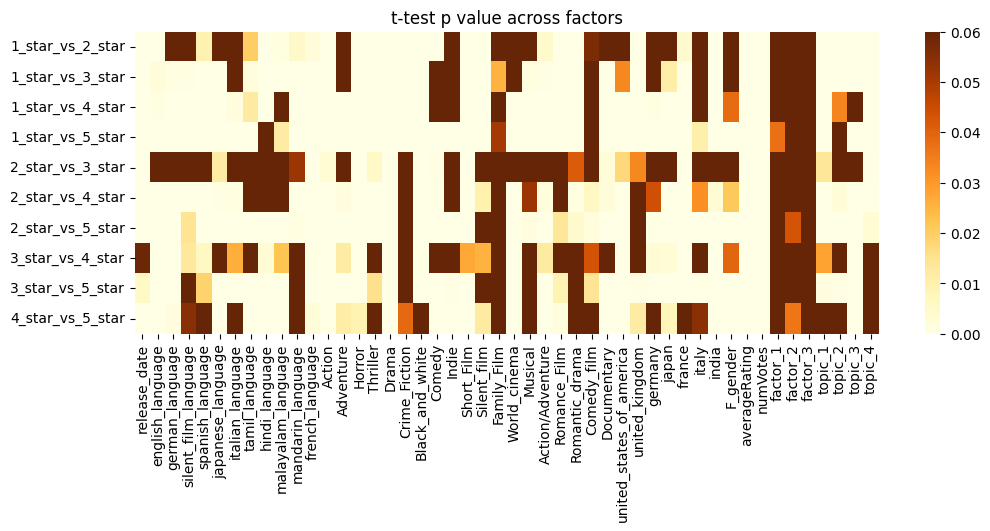

In [14]:
# Show t-test results
plt.figure(figsize = (12, 4), dpi = 100)
sns.heatmap(test_results, cmap = "YlOrBr", vmin = 0, vmax = 0.06)
plt.title("t-test p value across groups")
plt.show()

We immediately see that the separated groups are very different between each other. Except with respect to the factor assigned to them. This is cohesive, as we saw that grouping the movies by factor did not yield significative differences in average rating.

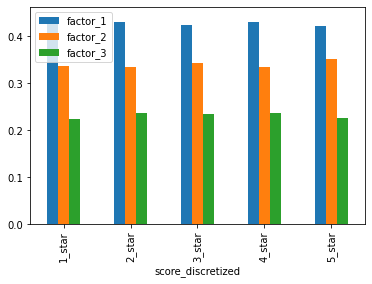

In [15]:
grouped[['factor_1','factor_2','factor_3']].mean().plot.bar()
plt.show()

We observe qualitatively that the factors are spreaded equally over stared groups. We will not use them for the rest of the analisis so we drop them.

In [16]:
data.drop(['factor_1','factor_2','factor_3'], axis = 1, inplace = True)

# max_star vs all approach

Now take a 1 vs all approach were we compare 5_star movies against the rest. This way we will contrast what makes a 5_star movie different from the rest.

In [17]:
# Divide dataset for logistic regression

# 1 vs all approach

def one_vs_all_encode(x, th):
    return np.where(x >= th, '5_star', 'other')

data['1vsall'] = one_vs_all_encode(data['score_discretized'] == '5_star', 0.5)

y = data['1vsall']

x_ = data.drop(['score_discretized', 'averageRating', 'numVotes', '1vsall', 'movie_name'], axis = 1)

X = (x_ - x_.mean(axis = 0)) / x_.std(axis = 0)

## Machine Learning

### Logistic Regression

We train a logistic regression model and analyze its coefficients

In [18]:
# Fit Model and retrieve coefficients
lr = LogisticRegression()
lr.fit(X,y)
coefs = lr.coef_.flatten()
print(f'Accuracy: {lr.score(X, y)}')

Accuracy: 0.7891726055415295


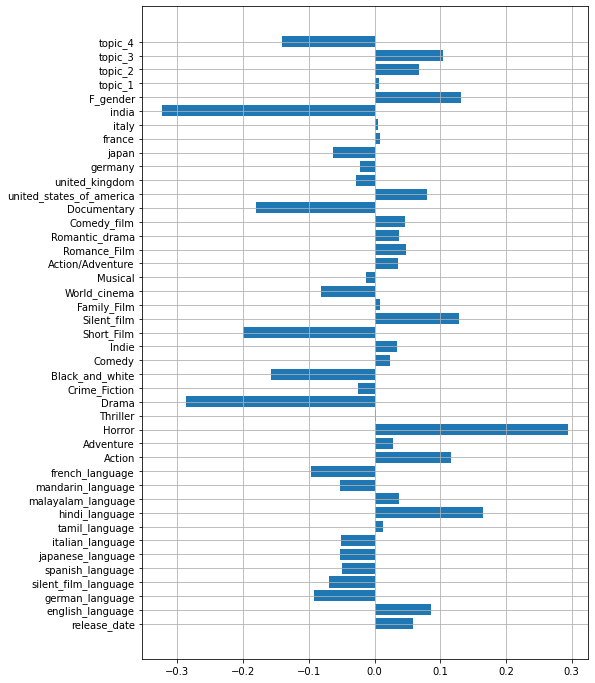

In [19]:
# Plot coefficients
plt.figure(figsize= (8,12))
plt.barh(range(len(coefs)), coefs)
plt.yticks(range(len(coefs)), labels = x_.columns)
plt.grid()
plt.show()

Next we do some analysis on the models prediction distribution

In [20]:
# Analyze model prediction distribution, check class imbalance effect. Select the threshold that maximizes f1 score

pred_space = pd.DataFrame({"score_discretized": y, "pred": lr.predict_proba(X)[:,0]})
best_cutoff = 0
best_f1 = 0

for th in np.linspace(0, 1, 25):
    f1 = f1_score(y, one_vs_all_encode(pred_space.pred, th), pos_label= '5_star')
    
    if f1 > best_f1:
        best_f1 = f1
        best_cutoff = th


best_accuracy = (one_vs_all_encode(pred_space.pred, best_cutoff) == y).sum() / len(y)
        
print(f"Best f1: {best_f1}, best cutoff: {best_cutoff}, best accuracy: {best_accuracy}")

Best f1: 0.4316133903850995, best cutoff: 0.20833333333333331, best accuracy: 0.6391614202166758


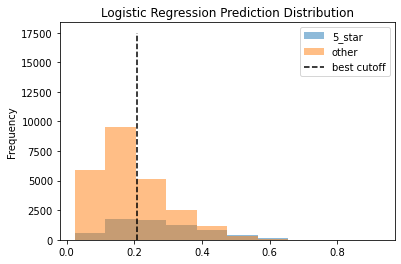

In [21]:
# Plot model prediction distribution
pred_space.pivot(columns = "score_discretized", values = 'pred').plot.hist(alpha = 0.5)
plt.title("Logistic Regression Prediction Distribution")
plt.vlines(best_cutoff, 0, 17500, 'k', linestyles = 'dashed', label = 'best cutoff')
plt.legend()
plt.show()

### Random Forest Classifier

We do the same with random forest classifier model

In [22]:
rf = RandomForestClassifier(10)

rf.fit(X, y)

importances = rf.feature_importances_

print(f"Random Forest accuracy: {rf.score(X, y)}")

Random Forest accuracy: 0.9919465661052699


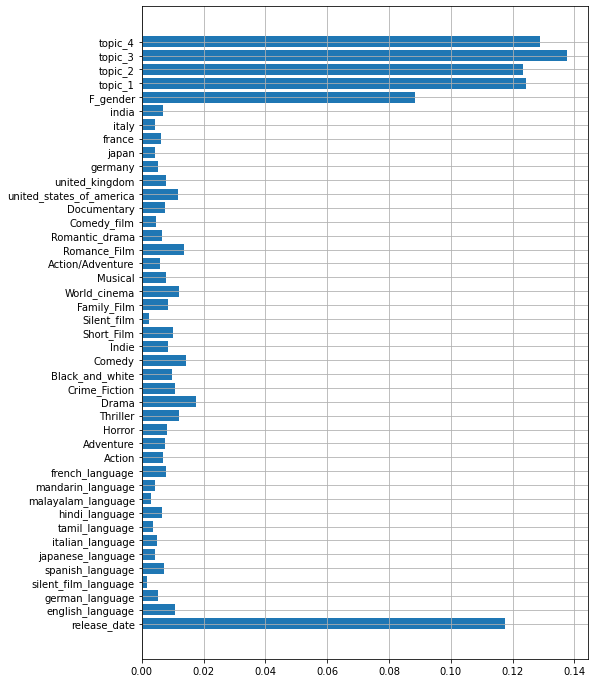

In [23]:
# Plot importances
plt.figure(figsize= (8,12))
plt.barh(range(len(importances)), importances)
plt.yticks(range(len(importances)), labels = x_.columns)
plt.grid()
plt.show()

In [24]:
# Analyze model prediction distribution, check class imbalance effect. Select the threshold that maximizes f1 score

pred_space = pd.DataFrame({"score_discretized": y, "pred": rf.predict_proba(X)[:,0]})
best_cutoff = 0
best_f1 = 0

for th in np.linspace(0, 1, 25):
    f1 = f1_score(y, one_vs_all_encode(pred_space.pred, th), pos_label= '5_star')
    
    if f1 > best_f1:
        best_f1 = f1
        best_cutoff = th


best_accuracy = (one_vs_all_encode(pred_space.pred, best_cutoff) == y).sum() / len(y)
        
print(f"Best f1: {best_f1}, best cutoff: {best_cutoff}, best accuracy: {best_accuracy}")

Best f1: 0.9809466202933615, best cutoff: 0.41666666666666663, best accuracy: 0.9919465661052699


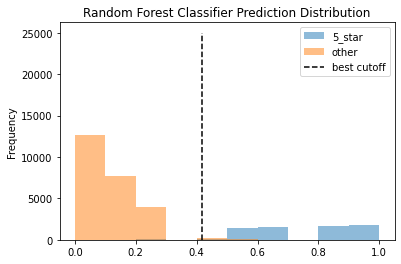

In [25]:
# Plot model prediction distribution
pred_space.pivot(columns = "score_discretized", values = 'pred').plot.hist(alpha = 0.5)
plt.title("Random Forest Classifier Prediction Distribution")
plt.vlines(best_cutoff, 0, 25000, 'k', linestyles = 'dashed', label = 'best cutoff')
plt.legend()
plt.show()

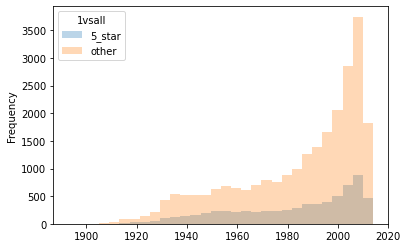

In [26]:
# Release date appears to be important in RF Lets plot its distribution

data.pivot(values = 'release_date', columns = "1vsall").plot.hist(alpha = 0.3, bins = 30)
plt.show()

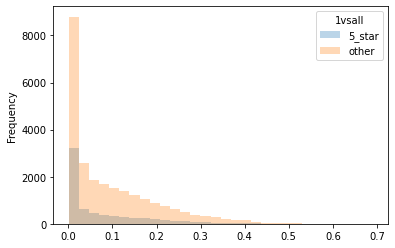

In [27]:
# also topics!!

data.pivot(values = 'topic_3', columns = "1vsall").plot.hist(alpha = 0.3, bins = 30)
plt.show()

## Testing means

Now we compare the data means with this same 1 vs all approach

In [28]:
data.columns

Index(['movie_name', 'release_date', 'english_language', 'german_language',
       'silent_film_language', 'spanish_language', 'japanese_language',
       'italian_language', 'tamil_language', 'hindi_language',
       'malayalam_language', 'mandarin_language', 'french_language', 'Action',
       'Adventure', 'Horror', 'Thriller', 'Drama', 'Crime_Fiction',
       'Black_and_white', 'Comedy', 'Indie', 'Short_Film', 'Silent_film',
       'Family_Film', 'World_cinema', 'Musical', 'Action/Adventure',
       'Romance_Film', 'Romantic_drama', 'Comedy_film', 'Documentary',
       'united_states_of_america', 'united_kingdom', 'germany', 'japan',
       'france', 'italy', 'india', 'F_gender', 'averageRating', 'numVotes',
       'topic_1', 'topic_2', 'topic_3', 'topic_4', 'score_discretized',
       '1vsall'],
      dtype='object')

In [29]:
grouped = data.drop(['movie_name','score_discretized'], axis = 1).groupby('1vsall')

In [30]:
test_results = tester(grouped, '1vsall', 0.05, correction = 'sidak', subtype = 'by_experiment')

>>>>>>>>>>>>>>>>>>>>>>>>>>
5_star vs other
_____________________________
45 t-tests with significance: 0.00057
_____________________________
Manifestation of underlying effect between groups in vars:
release_date -> pvalue: 5.61045723183364e-10
english_language -> pvalue: 1.7540050395148175e-85
german_language -> pvalue: 2.656213966637664e-27
spanish_language -> pvalue: 8.790026995903067e-05
japanese_language -> pvalue: 3.950590425347918e-16
italian_language -> pvalue: 4.0824722466961476e-07
tamil_language -> pvalue: 3.895424484145731e-20
hindi_language -> pvalue: 4.0718689220939463e-07
malayalam_language -> pvalue: 1.190153297626772e-10
french_language -> pvalue: 1.7122202829155277e-27
Action -> pvalue: 1.9207140882829139e-28
Adventure -> pvalue: 5.063363819548438e-09
Horror -> pvalue: 5.943461371490311e-72
Thriller -> pvalue: 2.0003011813194082e-10
Drama -> pvalue: 1.0319222445382127e-91
Black_and_white -> pvalue: 1.8186680347997783e-25
Comedy -> pvalue: 1.2418075822961275e-11
Indie 

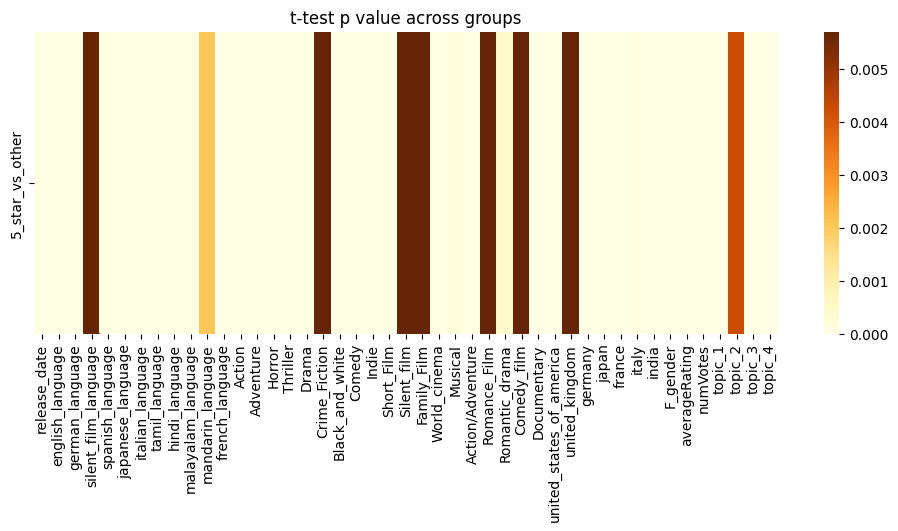

In [37]:
# Show t-test results
plt.figure(figsize = (12, 4), dpi = 100)
sns.heatmap(test_results, cmap = "YlOrBr", vmin = 0, vmax = 0.0057)
plt.title("t-test p value across groups")
plt.show()